In [3]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow_io as tfio
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

#### 1. Building Data Loading Function

In [2]:
CAPUCHIN_FILE = os.path.join('../data', 'Parsed_Capuchinbird_Clips', 'XC3776-0.wav')
NOT_CAPUCHIN_FILE = os.path.join('../data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [3]:
def load_wav_16k_mono(filename):
	""" Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
	# Loading the .wav file
	file_contents = tf.io.read_file(filename)
	# Decoding .wav file (tensors by channels)
	wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
	# Removing trailing axis
	wav = tf.squeeze(wav, axis=-1)
	sample_rate = tf.cast(sample_rate, dtype=tf.int64)
	# Goes from 44100Hz to 16000Hz
	wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
	return wav

#### 2. Plotting Waves

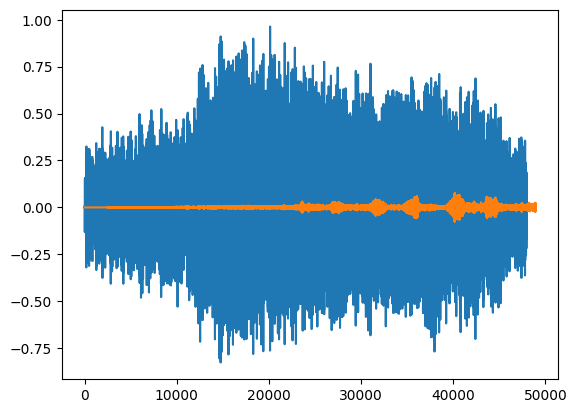

In [4]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)
plt.plot(wave)
plt.plot(nwave)
plt.show()

#### 3. Creating Tensorflow Dataset

In [5]:
# Defining Paths to Positive and Negative Data
POS = os.path.join('../data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('../data', 'Parsed_Not_Capuchinbird_Clips')

# Creating Tensorflow Dataset
pos = tf.data.Dataset.list_files(POS + '\*.wav')
neg = tf.data.Dataset.list_files(NEG + '\*.wav')

# Adding labels and combining pos and neg samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

# Combining positives and negatives
data = positives.concatenate(negatives)

#### 4. Finding Average Length of a Capuchin Call

In [6]:
# Calculating wave duration length
lengths = []
for file in os.listdir(os.path.join('../data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('../data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [7]:
# Calculating Min, Mean and Max of lengths
import numpy as np
print('Mean number of Samples : ', np.mean(lengths), '\nMean Duration (Sec) : ', np.mean(lengths) / 16000, '\n')
print('Min number of Samples : ', np.min(lengths), '\nMin Duration (Sec) : ', np.min(lengths) / 16000, '\n')
print('Max number of Samples : ', np.max(lengths), '\nMax Duration (Sec) : ', np.max(lengths) / 16000)

Mean number of Samples :  54156.66359447005 
Mean Duration (Sec) :  3.384791474654378 

Min number of Samples :  32000 
Min Duration (Sec) :  2.0 

Max number of Samples :  80000 
Max Duration (Sec) :  5.0


#### 5. Building Processing function to convert wave to spectrogram

In [9]:
# Preprocessing function
def preprocess(file_path, label):

	# Loading the file waves
	wav = load_wav_16k_mono(file_path)
	
	# Selecting first 48000 Samples from the audio
	wav = wav[:48000]
	
	# Some files might have < 48000 samples, so, padding remaining with 0s
	zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
	wav = tf.concat([zero_padding, wav], 0)

	# Creating a spectrogram (Applying Fourier Transform)
	spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
	spectrogram = tf.abs(spectrogram)
	spectrogram = tf.expand_dims(spectrogram, axis=2)

	return spectrogram, label

Positive Sample


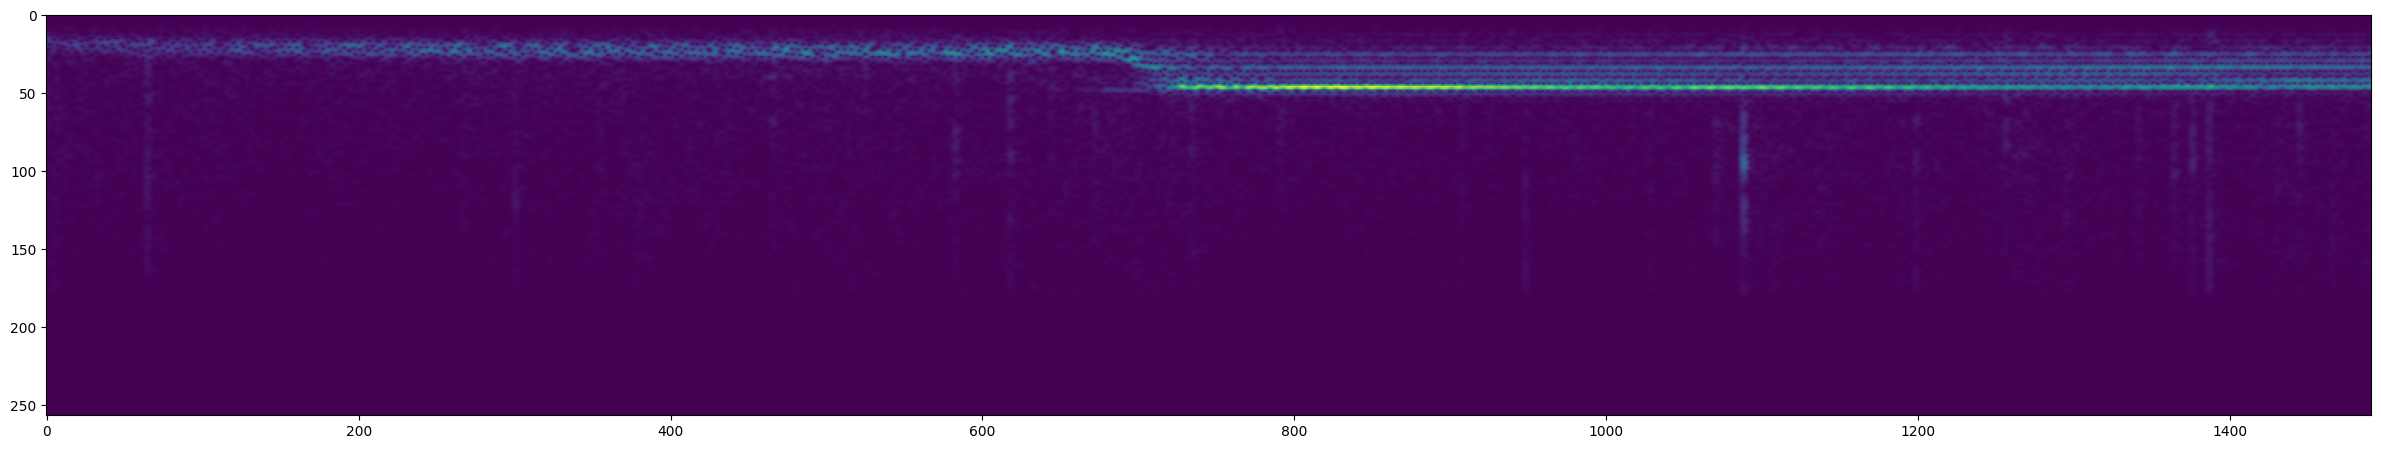

Negative Sample


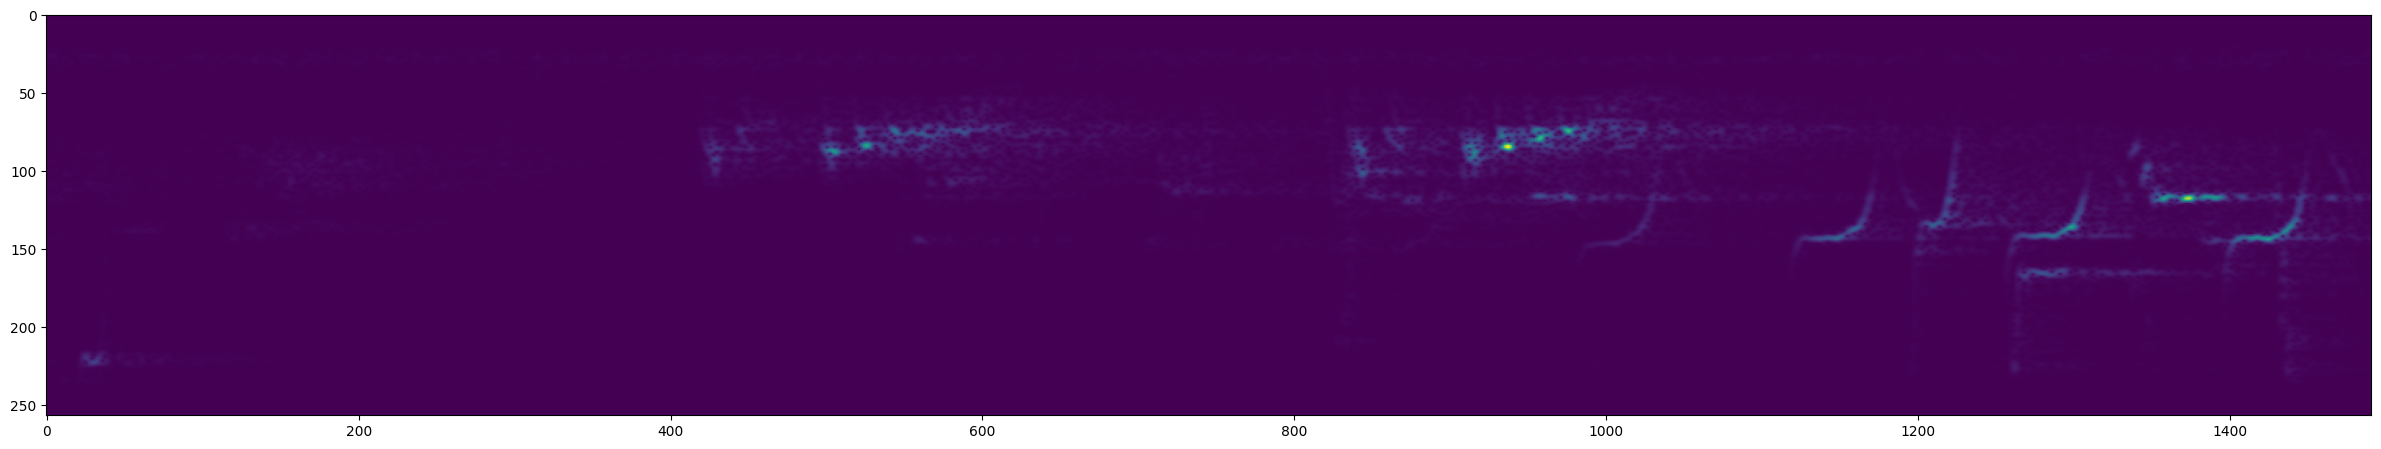

In [10]:
# Visualizing the Positive spectrogram
sample_pos, label_pos = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram_pos, label_pos = preprocess(sample_pos, label_pos)

plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectrogram_pos)[0])
print('Positive Sample')
plt.show()


# Visualizing the Negative spectrogram
sample_neg, label_neg = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram_neg, labelneg = preprocess(sample_neg, label_neg)

plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectrogram_neg)[0])
print('Negative Sample')
plt.show()

#### 6. Creating Training and Testing Sets

In [11]:
# creating Tensorflow Data Pipeline (MCSBP)
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
len(data) * 0.7

35.699999999999996

In [13]:
# Creating Train and Test Split
train = data.take(36)
test = data.skip(36).take(15)

In [15]:
# Testing a Sample batch
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

#### 7. Building CNN Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [17]:
# Building Sequential Model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 743, 126, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1497888)           0         
                                                                 
 dense (Dense)               (None, 128)               191729792 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [20]:
history = model.fit(train, epochs=4, validation_data=test, verbose=1)

Epoch 1/4


36/36 [==============================] - 161s 4s/step - loss: 3.4189 - recall: 0.5987 - precision: 0.7833 - val_loss: 0.1667 - val_recall: 0.6610 - val_precision: 1.0000
Epoch 2/4
36/36 [==============================] - 148s 4s/step - loss: 0.0796 - recall: 0.9007 - precision: 0.9927 - val_loss: 0.0121 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 148s 4s/step - loss: 0.0300 - recall: 0.9697 - precision: 0.9938 - val_loss: 0.0150 - val_recall: 0.9839 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 147s 4s/step - loss: 0.0088 - recall: 1.0000 - precision: 0.9936 - val_loss: 0.0110 - val_recall: 0.9836 - val_precision: 1.0000


#### 8. Plotting Loss and Metrics

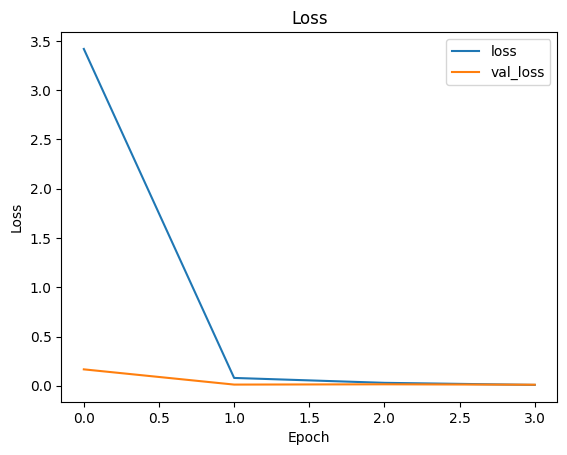

In [35]:
# Plotting Loss over Epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

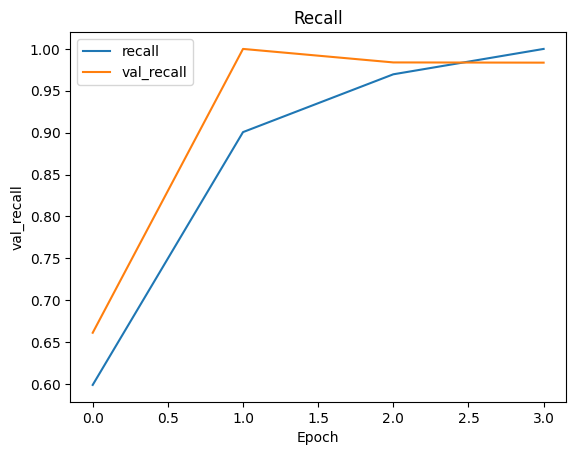

In [36]:
# Plotting Recall over Epochs
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.legend(['recall', 'val_recall'])
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('val_recall')
plt.show()

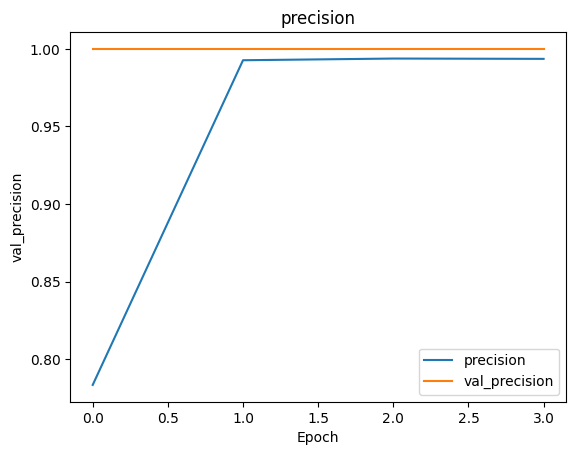

In [37]:
# Plotting Recall over Epochs
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.legend(['precision', 'val_precision'])
plt.title('precision')
plt.xlabel('Epoch')
plt.ylabel('val_precision')
plt.show()

#### 9. Making Predictions on Single Clip

In [48]:
# Get one batch and make predicitons
X_test, y_test = test.as_numpy_iterator().next()

# Doing Predictions
y_pred = model.predict(X_test)

# Convert logits to classes
y_pred = [1 if prediction > 0.5 else 0 for prediction in y_pred]

print('Predictions : ', y_pred)
print('True Labels : ', y_test)

1/1 [==============================] - 0s 397ms/step
Predictions :  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
True Labels :  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]


#### 10. Building Final Parsing Function

In [6]:
# Function for Loading MP3s as tensors
def load_mp3_16k_mono(filename):
	""" Load a MP3 file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
	# Loading the .mp3 file
	audio = tfio.audio.AudioIOTensor(filename)

	# Converting to tensor and combining channels
	tensor = tf.math.reduce_sum(audio.to_tensor(), axis=1) / 2

	# Extract sample_rate and cast
	sample_rate = audio.rate
	sample_rate = tf.cast(sample_rate, dtype=tf.int64)

	# Resampling to 16000 Hz
	wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)

	return wav

In [7]:
# Loading MP3s as tensors
mp3 = os.path.join('../data', 'Forest Recordings', 'recording_00.mp3')
wav = load_mp3_16k_mono(mp3)

# Slicing the audio tensor to 3 second slices (48000 Samples/Second ie; 16000Hz)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
samples, index = audio_slices.as_numpy_iterator().next()

In [8]:
# Function to preprocess audio slices to spectrograms
def preprocess_mp3(sample, text):
	sample = sample[0]
	
	# Adding zeropadding
	zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
	wav = tf.concat([zero_padding, sample], 0)
	
	# Creating Spectrogram
	spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
	spectrogram = tf.abs(spectrogram)
	spectrogram = tf.expand_dims(spectrogram, axis=2)
	
	return spectrogram

In [9]:
# Converting Clips to Slices and Predictions
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

# Doing Predictions	
y_pred = model.predict(audio_slices)
y_pred = [1 if prediction > 0.99 else 0 for prediction in y_pred]

# Grouping consecutive slices with same predictions
from itertools import groupby
y_pred = [key for key, group in groupby(y_pred)]
print('Total Number of Capuchin Bird Calls : ', tf.math.reduce_sum(y_pred).numpy())

1/1 [==============================] - 2s 2s/step
Total Number of Capuchin Bird Calls :  5


#### 11. Saving the model and Doing complete Predictions

In [83]:
# TensorFlow model
model.save('../Output/Model/capuchin_best_model.h5')

In [10]:
from tensorflow.keras.models import load_model

# Loading the model
model = load_model('../Output/Model/capuchin_best_model.h5')

In [ ]:
# Doing Prediction for the entire Forest
results = {}

for file in os.listdir(os.path.join('../data', 'Forest Recordings')):

	# Creating filepath
	FILEPATH = f"..\data\Forest Recordings\{file}"
	
	# Loading MP3s as tensors
	wav = load_mp3_16k_mono(FILEPATH)

	# Converting Clips to Slices and Predictions
	audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
	audio_slices = audio_slices.map(preprocess_mp3)
	audio_slices = audio_slices.batch(64)

	# Doing Predictions	
	y_pred = model.predict(audio_slices)
	y_pred = [1 if prediction > 0.99 else 0 for prediction in y_pred]
	y_pred = [key for key, group in groupby(y_pred)]

	# Saving to Dict
	results[file] = tf.math.reduce_sum(y_pred).numpy()

# Saving the results as csv
df = pd.DataFrame([results]).T
df = df.reset_index()
df.columns = ['Forest location', 'Density']
df.to_csv('../Output/Result/Result.csv', index=False)

### Final Inference

In [21]:
df[df['Density'] == df['Density'].max()]

,Forest location,Density
8,recording_08.mp3,25



From the Predictions, we can see that, Forest area with recording_08.mp3 have the highest density of capuchin_birds with 25 birds.
